In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
#Size of our input images
SIZE = 128

#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/global-wheat-detection/global-wheat-detection',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/global-wheat-detection/global-wheat-detection',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/global-wheat-detection/global-wheat-detection',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 3485 images belonging to 3 classes.
Found 3485 images belonging to 3 classes.
Found 3485 images belonging to 3 classes.


In [3]:
#Define the autoencoder. 
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3,3 ), activation='ELU', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='PReLU', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='ReLU', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='ELU', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='ReLU', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='ELU', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        149536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [4]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=25
        ,
        validation_data=validation_generator,
        
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/25
7/7 [==============================] - 60s 8s/step - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 2/25
7/7 [==============================] - 56s 8s/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0611 - val_mse: 0.0611
Epoch 3/25
7/7 [==============================] - 57s 8s/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 4/25
7/7 [==============================] - 57s 8s/step - loss: 0.0503 - mse: 0.0503 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 5/25
7/7 [==============================] - 57s 8s/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 6/25
7/7 [==============================] - 57s 8s/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 7/25
7/7 [==============================] - 56s 8s/step - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 8/25
7/7 [==============================] - 56s 8s/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0

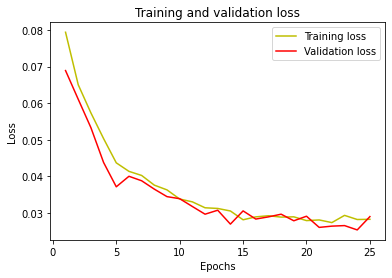

In [5]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()